In [1]:
# Import SVM 
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

#generating random sample
number_of_proper_data = 10000
number_of_anomal_data = 100
random_state = 42
rng = np.random.RandomState(random_state)

proper_data = rng.normal(loc=0.0, scale=1.0, size=[number_of_proper_data,1])
#anomalous_data = rng.normal(loc=5.0, scale=1.0, size=[number_of_anomal_data,1])

In [2]:
anomalous_data = rng.uniform(low=-100, high=100, size=(number_of_anomal_data, 1))

Plotting distribution of our data

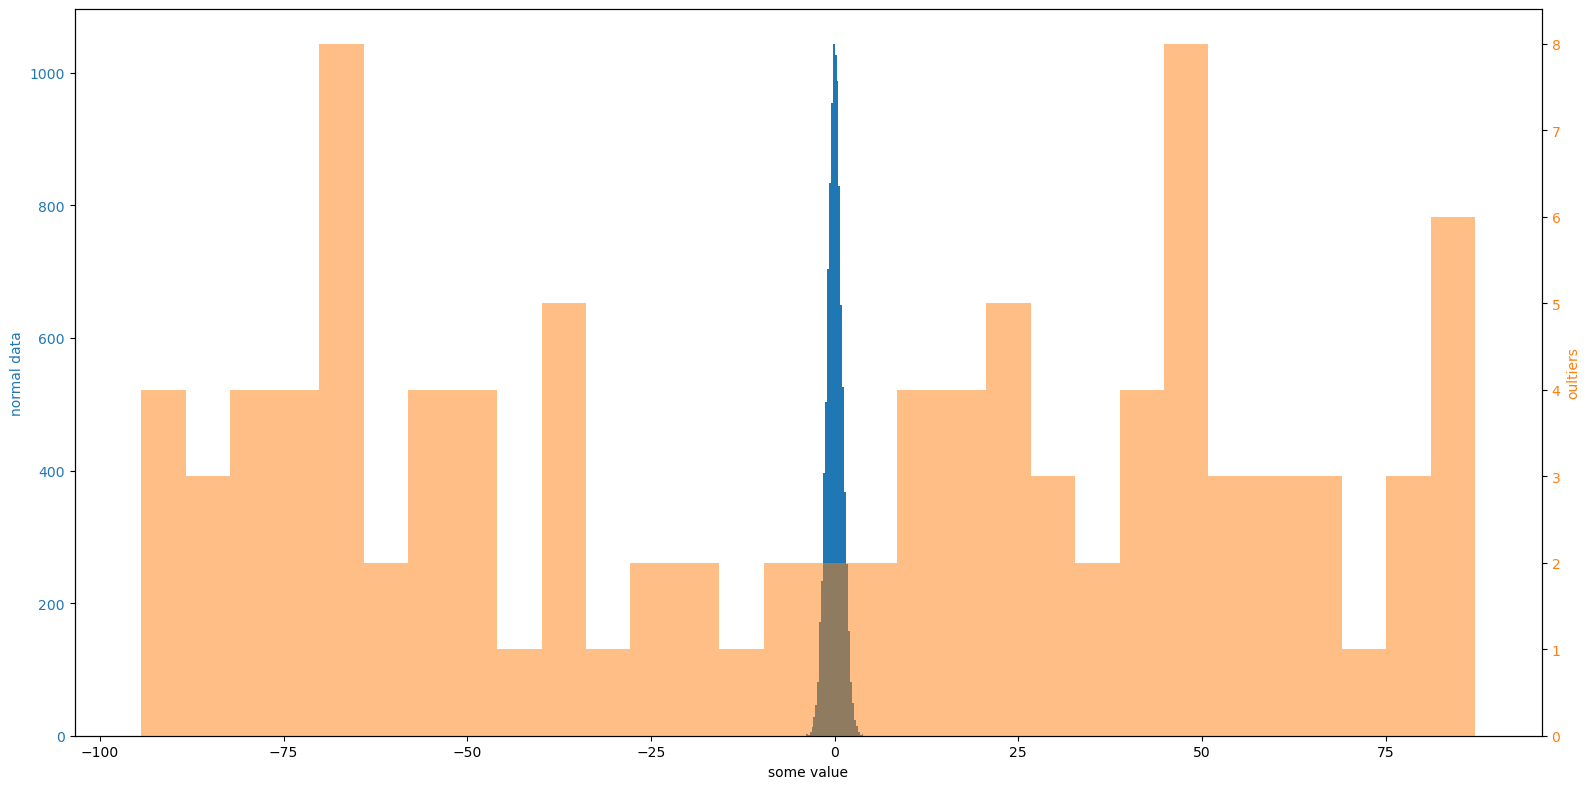

In [3]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:blue'
ax1.set_xlabel('some value')
ax1.set_ylabel('normal data', color=color)
ax1.hist(proper_data, 30)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('oultiers', color=color)  # we already handled the x-label with ax1
ax2.hist(anomalous_data, 30, color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [4]:
#preparing data for classifier
X = np.concatenate((proper_data, anomalous_data))


# making target data (we will use only for validation, not training)
y_proper = np.full((number_of_proper_data,), 1)
y_anomalous = np.full((number_of_anomal_data,), -1)
Y = np.concatenate((y_proper, y_anomalous))


Our data is prepared, let's train SVM classifier to detect anomalies. Hyperparameters was chosen using intuition.

In [5]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
# OCSVM hyperparameters
nu = 0.05
gamma = 2.0

# Fit the One-Class SVM
clf = OneClassSVM(gamma=gamma, kernel="sigmoid", nu=nu)
clf.fit(X)
y_pred = clf.predict(X)
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')

Accuracy score is:0.9498019801980198


Not bad, but we need to chose hyperparameters which will suit our model better. Also, I will add another metric - F1-score.
Here I will use new experimental method from scikit learn which can choose better hyperparameter set, based on chosen metric.

In [6]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score

param_grid = {  'gamma': [2, 1, 3, 0.1, 4.5, 5],
                'kernel': ["sigmoid", "rbf", "linear"],
                'nu':[0.05, 0.01, 0.02, 0.5, 0.005, 0.001, 0.0005]}

base_estimator = OneClassSVM()

sh = HalvingGridSearchCV(base_estimator, param_grid, scoring = make_scorer(f1_score)).fit(X, Y)
sh.best_estimator_

OneClassSVM(gamma=4.5, kernel='sigmoid', nu=0.005)

Now we have best estimator for our case. We can directly put it inside our classificator.

In [7]:
# Fit the One-Class SVM
clf = sh.best_estimator_
clf.fit(X)
y_pred = clf.predict(X)
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')
print(f'F1 score is:{f1_score(Y, y_pred)}')


Accuracy score is:0.9883168316831683
F1 score is:0.9941147132169575


Result is even better! 

Extra: while reading about one-class SVM I have noticed information about Local Outlier Factor (LOF). Which is more suitable for intrsion detection (Reference:https://en.wikipedia.org/wiki/Local_outlier_factor). Here my implementation.

In [8]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor()
y_pred=clf.fit_predict(X)
print(f'Accuracy score is:{accuracy_score(Y, y_pred)}')
print(f'F1 score is:{f1_score(Y, y_pred)}')


Accuracy score is:0.9905940594059406
F1 score is:0.9952658593711068


I want to say, that LOF is really better than one-class SVM and it doesn't need any setup.